In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import eli5, shap
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from lightgbm.sklearn import LGBMRegressor

In [2]:
df = pd.read_csv("parkade_data/processed_thunderbird_2014.csv", parse_dates=["TimestampLocal"])
df = df.rename(columns={'TimestampLocal': 'Timestamp', 'TimestampLocal.total_count': 'total_count'})
df.head(10)

,Timestamp,total_count,parkade
0,2014-01-01,52,Thunderbird
1,2014-01-02,119,Thunderbird
2,2014-01-03,705,Thunderbird
3,2014-01-04,874,Thunderbird
4,2014-01-05,579,Thunderbird
5,2014-01-06,681,Thunderbird
6,2014-01-07,316,Thunderbird
7,2014-01-08,254,Thunderbird
8,2014-01-09,1386,Thunderbird
9,2014-01-10,1571,Thunderbird


In [3]:
# df = df.drop(df[(df.Timestamp >= "2020-02-01") & (df.Timestamp < "2021-09-01")].index)
print(df["Timestamp"].min())
print(df["Timestamp"].max())
print(df["Timestamp"].count())

2014-01-01 00:00:00
2023-02-02 00:00:00
3320


In [4]:
def get_season(month):
    SUMMER_MONTHS = [6, 7, 8] 
    SPRING_MONTHS = [3, 4, 5]
    WINTER_MONTHS = [12, 1, 2]
    FALL_MONTHS = [9, 10, 11]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in FALL_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Spring"

In [5]:
def get_school_term(month):
    SUMMER_TERM = [5, 6, 7, 8]
    WINTER_TERM = [9, 10, 11, 12]
    SPRING_TERM = [1, 2, 3, 4]
    
    if month in SUMMER_TERM:
        return "Summer_term"
    elif month in WINTER_TERM:
        return "Winter_term"
    else:
        return "Spring_term"

In [6]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}_{n}_days_ago": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [7]:
df['year'] = pd.DatetimeIndex(df['Timestamp']).year
df['month'] = pd.DatetimeIndex(df['Timestamp']).month
df['day'] = pd.DatetimeIndex(df['Timestamp']).day
df['day_of_week'] = pd.DatetimeIndex(df['Timestamp']).day_name()
df = df.assign(season=df["month"].apply(get_season))
df = df.assign(term=df["month"].apply(get_school_term))
df = create_lag_df(df, 7, ['total_count'])

In [8]:
df.head(10)

,Timestamp,total_count,parkade,year,month,day,day_of_week,season,term,total_count_1_days_ago,total_count_2_days_ago,total_count_3_days_ago,total_count_4_days_ago,total_count_5_days_ago,total_count_6_days_ago,total_count_7_days_ago
0,2014-01-01,52,Thunderbird,2014,1,1,Wednesday,Winter,Spring_term,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-02,119,Thunderbird,2014,1,2,Thursday,Winter,Spring_term,52.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-03,705,Thunderbird,2014,1,3,Friday,Winter,Spring_term,119.0,52.0,NaN,NaN,NaN,NaN,NaN
3,2014-01-04,874,Thunderbird,2014,1,4,Saturday,Winter,Spring_term,705.0,119.0,52.0,NaN,NaN,NaN,NaN
4,2014-01-05,579,Thunderbird,2014,1,5,Sunday,Winter,Spring_term,874.0,705.0,119.0,52.0,NaN,NaN,NaN
5,2014-01-06,681,Thunderbird,2014,1,6,Monday,Winter,Spring_term,579.0,874.0,705.0,119.0,52.0,NaN,NaN
6,2014-01-07,316,Thunderbird,2014,1,7,Tuesday,Winter,Spring_term,681.0,579.0,874.0,705.0,119.0,52.0,NaN
7,2014-01-08,254,Thunderbird,2014,1,8,Wednesday,Winter,Spring_term,316.0,681.0,579.0,874.0,705.0,119.0,52.0
8,2014-01-09,1386,Thunderbird,2014,1,9,Thursday,Winter,Spring_term,254.0,316.0,681.0,579.0,874.0,705.0,119.0
9,2014-01-10,1571,Thunderbird,2014,1,10,Friday,Winter,Spring_term,1386.0,254.0,316.0,681.0,579.0,874.0,705.0


In [9]:
# processed_thunderbird_2014.csv, dropped covid data splits
# 80-20 split
split_date = "2020-01-03 0:00"
# 90-10 split
# split_date = "2022-08-22 0:00"

df_train = df[df["Timestamp"] <= split_date]
df_test = df[df["Timestamp"] > split_date]
assert(len(df_train) + len(df_test) == len(df))

print(df_train.shape)
print(df_test.shape)
print(np.average(df_train["total_count"]))

(2194, 16)
(1126, 16)
966.1112123974476


In [10]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):
    all_features = set(numeric_features + categorical_features + drop_features + target)
    
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    # Apply imputation and scaling to numerical features 
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    
    # Apply imputation and One-Hot encoding to categorical features
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )
    
    # Define a column transformer
    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["total_count"]
    y_test = test_df["total_count"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [11]:
# Categorize and preprocess features
numeric_features = ["year", "month", "day", "total_count_1_days_ago", "total_count_2_days_ago", "total_count_3_days_ago", 
                    "total_count_4_days_ago", "total_count_5_days_ago", "total_count_6_days_ago", "total_count_7_days_ago"]
categorical_features = ["day_of_week", "season", "term"]
# drop_features = ["Timestamp"]
drop_features = ["Timestamp", "parkade"]
target = ["total_count"]

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features,
    drop_features,
    target
)

# Get all the feature names for later use
ohe_feats = (
    preprocessor.named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
).tolist()
feature_names = numeric_features + ohe_feats
print(feature_names)
print(len(feature_names))

X_train_enc.head(5)

['year', 'month', 'day', 'total_count_1_days_ago', 'total_count_2_days_ago', 'total_count_3_days_ago', 'total_count_4_days_ago', 'total_count_5_days_ago', 'total_count_6_days_ago', 'total_count_7_days_ago', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter', 'term_Spring_term', 'term_Summer_term', 'term_Winter_term']
24


,year,month,day,total_count_1_days_ago,total_count_2_days_ago,total_count_3_days_ago,total_count_4_days_ago,total_count_5_days_ago,total_count_6_days_ago,total_count_7_days_ago,...,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,season_Autumn,season_Spring,season_Summer,season_Winter,term_Spring_term,term_Summer_term,term_Winter_term
0,-1.46363,-1.597986,-1.669929,-0.222904,-0.222721,-0.222591,-0.222432,-0.2222,-0.222795,-0.223449,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,-1.46363,-1.597986,-1.556389,-1.589380,-0.222721,-0.222591,-0.222432,-0.2222,-0.222795,-0.223449,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-1.46363,-1.597986,-1.442849,-1.472900,-1.590741,-0.222591,-0.222432,-0.2222,-0.222795,-0.223449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-1.46363,-1.597986,-1.329309,-0.454127,-1.474203,-1.592239,-0.222432,-0.2222,-0.222795,-0.223449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-1.46363,-1.597986,-1.215769,-0.160317,-0.454928,-1.475637,-1.593661,-0.2222,-0.222795,-0.223449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [12]:
print(X_train_enc.shape)
print(y_train.shape)
print(X_test_enc.shape)
print(y_test.shape)

(2194, 24)
(2194,)
(1126, 24)
(1126,)


In [13]:
# Hyperparameter Tuning
# lgbm_pipe = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
# lgbm_param_grid = {
#     "lgbmregressor__n_estimators": np.arange(40, 70, 1, dtype=int),
#     "lgbmregressor__max_depth": np.arange(1, 6, 1, dtype=int),
#     "lgbmregressor__num_leaves": np.arange(5, 15, 1, dtype=int),
#     "lgbmregressor__learning_rate": [0.01, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# }

# lgbm_grid_search = GridSearchCV(
#     lgbm_pipe, lgbm_param_grid, n_jobs=-1, cv=TimeSeriesSplit(), return_train_score=True
# )

# lgbm_grid_search.fit(df_train, y_train)
# print(lgbm_grid_search.best_score_)
# print(lgbm_grid_search.best_params_)

In [14]:
# Create the pipeline again using the optimal hyperparameters we found
lgbm_pipe = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
# lgbm_pipe = make_pipeline(preprocessor, LGBMRegressor(random_state=123, learning_rate=0.15, max_depth=5, n_estimators=68, num_leaves=14))
lgbm_pipe.fit(df_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month', 'day',
                                                   'total_count_1_days_ago',
                                                   'total_count_2_days_ago',
                                                   'total_count_3_days_ago',
                                                   'total_count_4_days_ago',
                                                   'total_count_5_days_ago',
                                                   'total_count_6_days_ago',
                                                   'total_count_7_days_ago']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day_of_week', 'season',
                                                   'term']),
                                                 ('drop', 'drop',
                                                  ['Timestamp', 'parkade'])])),
                ('lgbmregressor', LGBMRegressor(random_state=123))])

In [15]:
scores = cross_validate(
    lgbm_pipe, df_train, y_train, cv=TimeSeriesSplit(), return_train_score=True
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.117150,0.003062,0.806697,0.939275
1,0.206011,0.003144,0.883893,0.984175
2,0.239719,0.003557,0.894039,0.987073
3,0.246388,0.003218,0.923758,0.985229
4,0.246110,0.003243,0.905895,0.982683


In [16]:
print(lgbm_pipe.steps[1][1].learning_rate)
print(lgbm_pipe.steps[1][1].n_estimators)
print(lgbm_pipe.steps[1][1].max_depth)
print(lgbm_pipe.steps[1][1].num_leaves)

0.1
100
-1
31


In [17]:
# Look at Feature Importance
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html#feature-importance-by-permutation
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

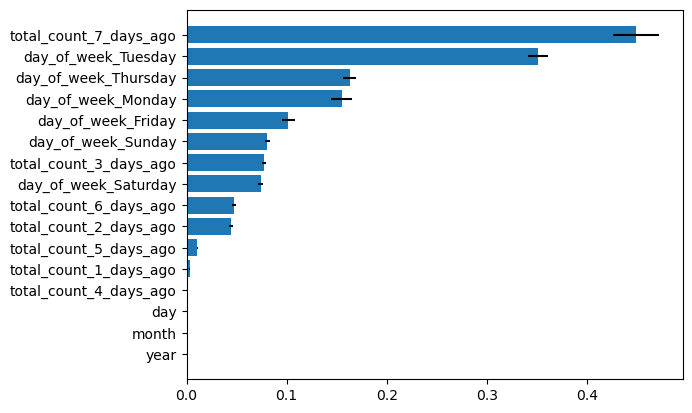

In [18]:
perm_importance_result_train = permutation_importance(
    lgbm_pipe, df_train, y_train, n_repeats=10)

plot_feature_importances(perm_importance_result_train, X_train_enc.columns)

In [19]:
eli5.explain_weights(
    lgbm_pipe.named_steps["lgbmregressor"], feature_names=feature_names
)

Weight,Feature
0.3554,total_count_7_days_ago
0.2042,total_count_1_days_ago
0.0815,total_count_3_days_ago
0.0781,total_count_6_days_ago
0.0627,total_count_2_days_ago
0.0593,total_count_5_days_ago
0.0588,day
0.0474,total_count_4_days_ago
0.0285,month
0.0105,term_Summer_term


In [20]:
# Final model performance
print("R^2 score on training set: {:.3f}".format(r2_score(y_train, lgbm_pipe.predict(df_train))))
print("R^2 score on test set: {:.3f}".format(r2_score(y_test, lgbm_pipe.predict(df_test))))
print("Mean Absolute Percentage Error on training set: {:.3f}%".format(mean_absolute_percentage_error(y_train, lgbm_pipe.predict(df_train)) * 100))
print("Mean Absolute Percentage Error on testing set: {:.3f}%".format(mean_absolute_percentage_error(y_test, lgbm_pipe.predict(df_test)) * 100))
print("Mean Absolute Error on testing set: {:.0f}".format(mean_absolute_error(y_train, lgbm_pipe.predict(df_train))))
print("Mean Absolute Error on testing set: {:.0f}".format(mean_absolute_error(y_test, lgbm_pipe.predict(df_test))))

R^2 score on training set: 0.979
R^2 score on test set: 0.882
Mean Absolute Percentage Error on training set: 10.113%
Mean Absolute Percentage Error on testing set: 20.029%
Mean Absolute Error on testing set: 60
Mean Absolute Error on testing set: 132


**Metrics** 

| Category | R^2 | MAE | MAPE |
| -------- | --------- | ------ | -------- |
| Training | 0.979 | 60 | 10.11% |   
| Test | 0.882 | 132 | 20.02% |  

In [21]:
# y_test_and_pred = df_test.loc[:, ["total_count"]]
# y_test_and_pred["prediction"] = lgbm_pipe.predict(df_test).tolist()
# y_test_and_pred["Date"] = pd.DatetimeIndex(df_test["Timestamp"]).date
# print(y_test_and_pred)

# Skip covid data
y_test_and_pred = df_test.loc[2801:, ["total_count"]]
y_test_and_pred["prediction"] = lgbm_pipe.predict(df_test.loc[2801:]).tolist()
y_test_and_pred["Date"] = pd.DatetimeIndex(df_test.loc[2801:]["Timestamp"]).date
print(y_test_and_pred)

      total_count   prediction        Date
2801          737   855.219912  2021-09-02
2802         1257  1146.763419  2021-09-03
2803          181   313.748087  2021-09-04
2804          233   502.767892  2021-09-05
2805         1397  1241.351133  2021-09-06
...           ...          ...         ...
3315          612   822.187803  2023-01-29
3316         1678  1741.177801  2023-01-30
3317         1583  1794.111604  2023-01-31
3318         1824  1497.021728  2023-02-01
3319         1513  1476.584224  2023-02-02

[519 rows x 3 columns]


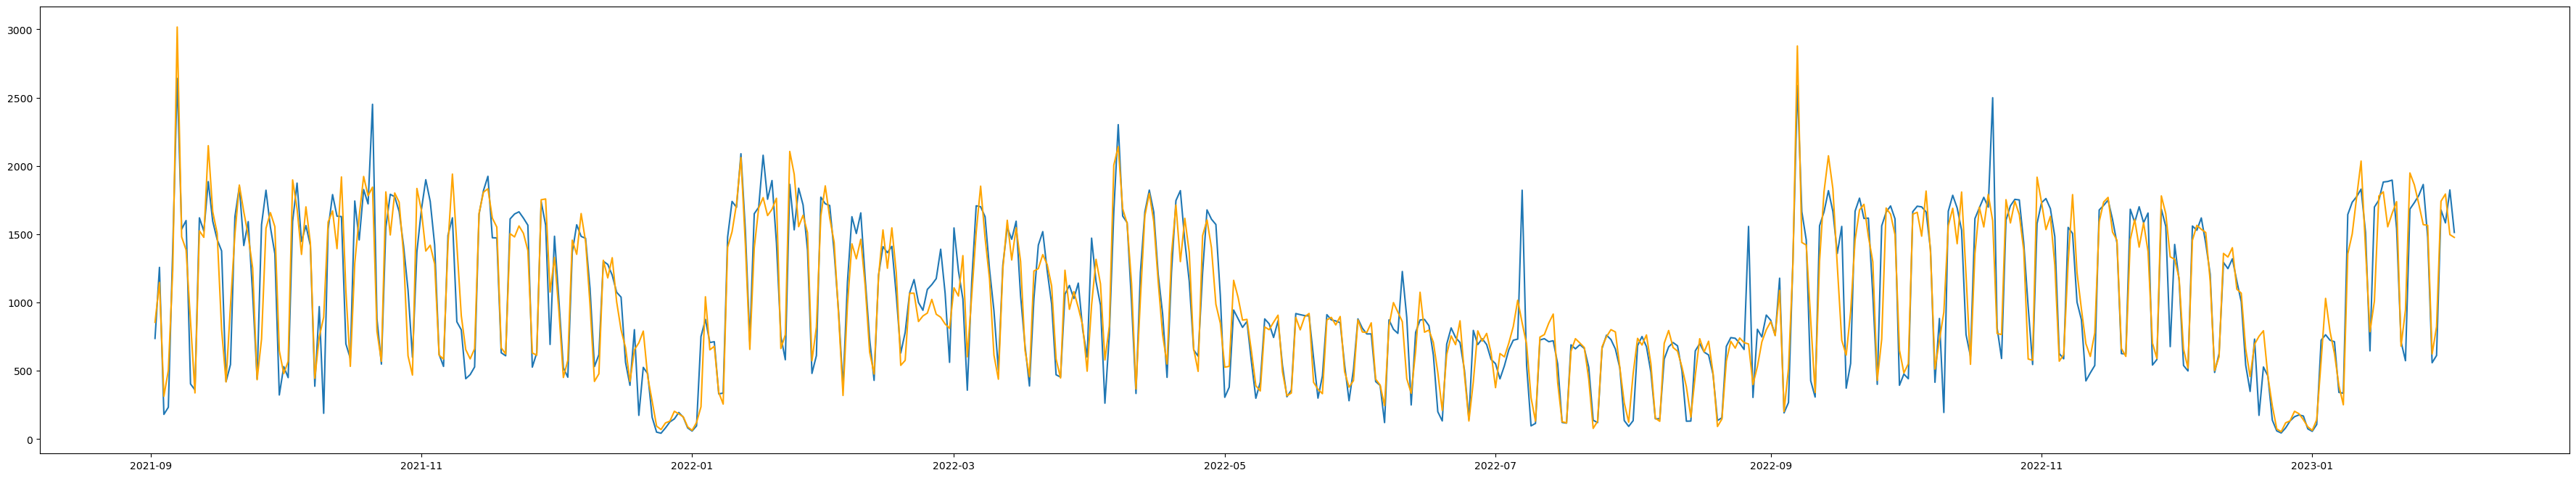

In [22]:
# Plots
plt.figure(figsize=(45, 8))
plt.plot(y_test_and_pred["Date"], y_test_and_pred["total_count"])
plt.plot(y_test_and_pred["Date"], y_test_and_pred["prediction"], color="orange")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


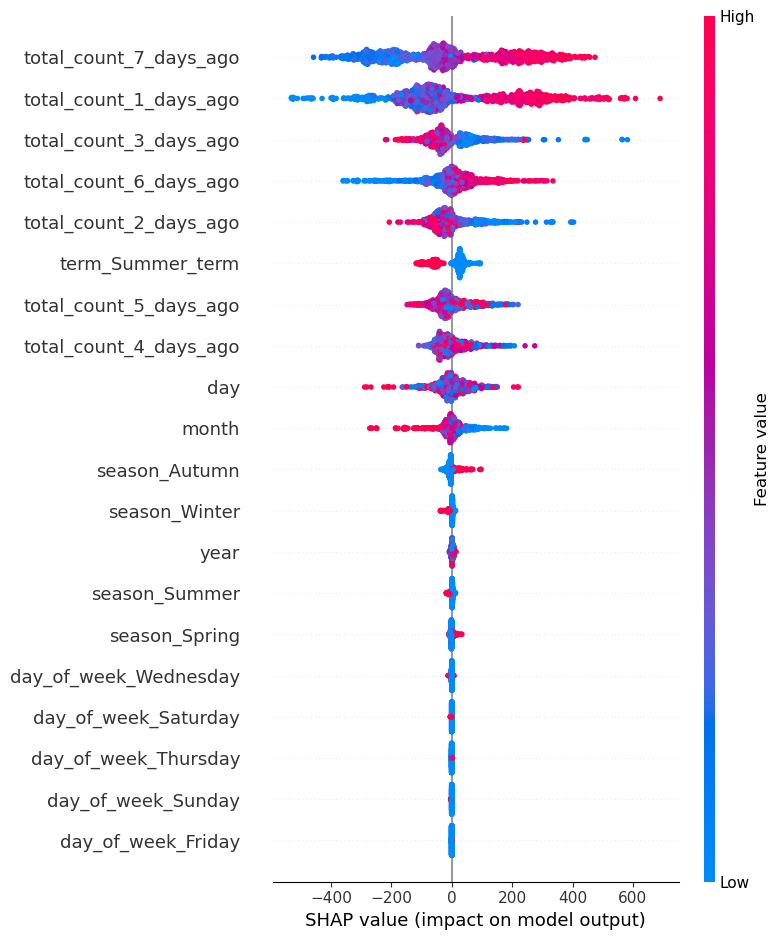

In [23]:
# Feature importance on the test data
lgbm_explainer = shap.TreeExplainer(lgbm_pipe.named_steps["lgbmregressor"])
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)
shap.summary_plot(test_lgbm_shap_values, X_test_enc)

In [24]:
# visualize the first prediction's explaination with default colors
shap.force_plot(lgbm_explainer.expected_value, test_lgbm_shap_values[0,:], X_test_enc.iloc[0,:])

In [25]:
shap.initjs()
shap.force_plot(lgbm_explainer.expected_value, test_lgbm_shap_values, X_test_enc)

<h1>
    Packaging the model
</h1>

In [26]:
# Experimenting with predict()
print(df_test.head(1))

      Timestamp  total_count      parkade  year  month  day day_of_week  \
2194 2020-01-04          946  Thunderbird  2020      1    4    Saturday   

      season         term  total_count_1_days_ago  total_count_2_days_ago  \
2194  Winter  Spring_term                   611.0                   111.0   

      total_count_3_days_ago  total_count_4_days_ago  total_count_5_days_ago  \
2194                    62.0                    91.0                   160.0   

      total_count_6_days_ago  total_count_7_days_ago  
2194                   201.0                   146.0  


In [27]:
# Create new features
def create_features(data): 
    def get_season(month):
        SUMMER_MONTHS = [6, 7, 8] 
        SPRING_MONTHS = [3, 4, 5]
        WINTER_MONTHS = [12, 1, 2]
        FALL_MONTHS = [9, 10, 11]
        if month in WINTER_MONTHS:
            return "Winter"
        elif month in FALL_MONTHS:
            return "Autumn"
        elif month in SUMMER_MONTHS:
            return "Summer"
        else:
            return "Spring"
    
    def get_school_term(month):
        SUMMER_TERM = [5, 6, 7, 8]
        WINTER_TERM = [9, 10, 11, 12]
        SPRING_TERM = [1, 2, 3, 4]

        if month in SUMMER_TERM:
            return "Summer_term"
        elif month in WINTER_TERM:
            return "Winter_term"
        else:
            return "Spring_term"
        
    def create_lag_df(df, lag, cols):
        return df.assign(
            **{f"{col}_{n}_days_ago": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
        )

    new_df = pd.DataFrame(data)
    new_df['year'] = pd.DatetimeIndex(new_df['Timestamp']).year
    new_df['month'] = pd.DatetimeIndex(new_df['Timestamp']).month
    new_df['day'] = pd.DatetimeIndex(new_df['Timestamp']).day
    new_df['day_of_week'] = pd.DatetimeIndex(new_df['Timestamp']).day_name()
    new_df = new_df.assign(season=new_df["month"].apply(get_season))
    new_df = new_df.assign(term=new_df["month"].apply(get_school_term))
    new_df = create_lag_df(new_df, 7, ['total_count'])
    
    return new_df

In [28]:
# Total count will be dropped, so just put anything
new_data = [{"Timestamp": "2023-02-03", "total_count": 1233, "parkade": "Thunderbird"},
           {"Timestamp": "2023-02-04", "total_count": 2341, "parkade": "Thunderbird"},
           {"Timestamp": "2023-02-05", "total_count": 2413, "parkade": "Thunderbird"},
           {"Timestamp": "2023-02-06", "total_count": 3145, "parkade": "Thunderbird"},
           {"Timestamp": "2023-02-07", "total_count": 1546, "parkade": "Thunderbird"},
           {"Timestamp": "2023-02-08", "total_count": 1752, "parkade": "Thunderbird"},
           {"Timestamp": "2023-02-09", "total_count": 1123, "parkade": "Thunderbird"},
           {"Timestamp": "2023-02-10", "total_count": 2341, "parkade": "Thunderbird"}]

new_df = create_features(new_data)
lgbm_pipe.predict(new_df)

array([ 495.65530692,  479.05973695, 1120.922655  , 1009.70573053,
       1324.07234449, 1188.42088359, 1122.50319497, 1009.97926391])

In [29]:
# Saving the model
with open("saved_model/tree_model.joblib", "wb") as f:
    joblib.dump(lgbm_pipe, f)